# ARCH Modeling

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
seaborn.set_style('darkgrid')

In [2]:
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

### Setup

These examples will all make use of financial data from Yahoo! Finance imported using `pandas-datareader`.  

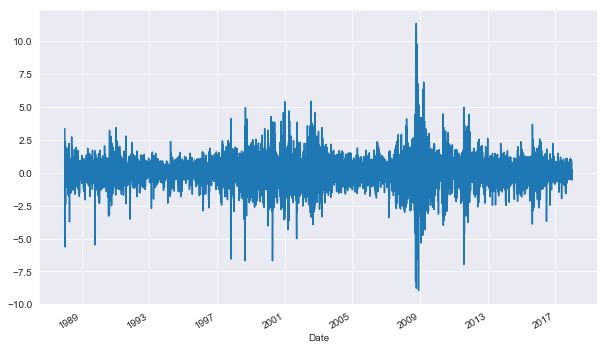

In [3]:
import datetime as dt
import pandas_datareader.data as web
st = dt.datetime(1988,1,1)
en = dt.datetime(2018,1,1)
data = web.get_data_famafrench('F-F_Research_Data_Factors_daily', start=st, end=en)
mkt_returns = data[0]['Mkt-RF'] +  data[0]['RF']
returns = mkt_returns
figure = returns.plot()

## Specifying Common Models

The simplest way to specify a model is to use the model constructor `arch.arch_model` which can specify most common models.  The simplest invocation of `arch` will return a model with a constant mean, GARCH(1,1) volatility process and normally distributed errors.


$$ r_t  =  \mu + \epsilon_t$$

$$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$

$$\epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  N(0,1) $$


The model is estimated by calling `fit`.  The optional inputs `iter` controls the frequency of output form the optimizer, and `disp` controls whether convergence information is returned.  The results class returned offers direct access to the estimated parameters and related quantities, as well as a `summary` of the estimation results.

### GARCH (with a Constant Mean)

The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

In [4]:
from arch import arch_model
am = arch_model(returns) 
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     41,   Neg. LLF: 9820.639709370564
Iteration:     10,   Func. Count:     74,   Neg. LLF: 9817.274895770548
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9817.274187120373
            Iterations: 13
            Function evaluations: 92
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -9817.27
Distribution:                  Normal   AIC:                           19642.5
Method:            Maximum Likelihood   BIC:                           19670.3
                                        No. Observations:                 7561
Date:                Sun, Aug 19 2018   Df Residuals:                     7557
Time:         

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.  

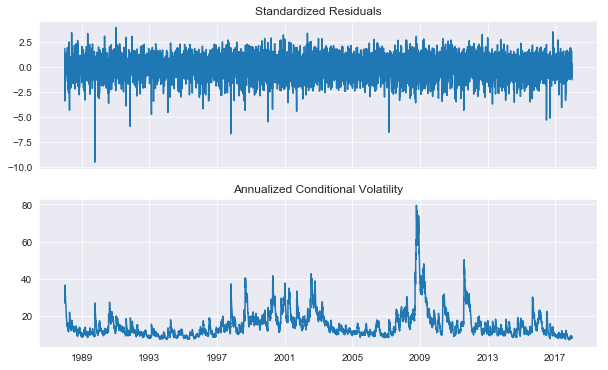

In [5]:
fig = res.plot(annualize='D')

### GJR-GARCH

Additional inputs can be used to construct other models.  This example sets `o` to 1, which includes one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics given by 

$$
\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \gamma \epsilon_{t-1}^2 I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^2 
$$

where $I$ is an indicator function that takes the value 1 when its argument is true.

The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is highly significant.

In [6]:
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -9713.51
Distribution:                  Normal   AIC:                           19437.0
Method:            Maximum Likelihood   BIC:                           19471.7
                                        No. Observations:                 7561
Date:                Sun, Aug 19 2018   Df Residuals:                     7556
Time:                        21:33:03   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0442  8.759e-03      5.051  4.398e-07 [2.

### TARCH/ZARCH

TARCH (also known as ZARCH) model the _volatility_ using absolute values.  This model is specified using `power=1.0` since the default power, 2, corresponds to variance processes that evolve in squares.

The volatility process in a TARCH model is given by 

$$
\sigma_t  =  \omega + \alpha \left|\epsilon_{t-1}\right| + \gamma \left|\epsilon_{t-1}\right| I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1} 
$$

More general models with other powers ($\kappa$) have volatility dynamics given by 

$$
\sigma_t^\kappa   = \omega + \alpha \left|\epsilon_{t-1}\right|^\kappa + \gamma \left|\epsilon_{t-1}\right|^\kappa I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^\kappa 
$$

where the conditional variance is $\left(\sigma_t^\kappa\right)^{2/\kappa}$.

The TARCH model also improves the fit, although the change in the log likelihood is less dramatic.

In [7]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     54,   Neg. LLF: 9701.46915224492
Iteration:     10,   Func. Count:     94,   Neg. LLF: 9685.575185675976
Iteration:     15,   Func. Count:    130,   Neg. LLF: 9683.248100354442
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9683.248099008848
            Iterations: 16
            Function evaluations: 137
            Gradient evaluations: 16
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -9683.25
Distribution:                  Normal   AIC:                           19376.5
Method:            Maximum Likelihood   BIC:                           19411.1
                                        No. Observations:                 7561
Date:                

### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature.  The call to `arch` changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 10.  The log-likelihood also shows a large increase.

In [8]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     56,   Neg. LLF: 9535.100867863783
Iteration:     10,   Func. Count:    100,   Neg. LLF: 9506.165300845836
Iteration:     15,   Func. Count:    140,   Neg. LLF: 9505.38232521017
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9505.381447531525
            Iterations: 17
            Function evaluations: 156
            Gradient evaluations: 17
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -9505.38
Distribution:      Standardized Student's t   AIC:                           19022.8
Method:                  Maximum Likelihood   BIC:                           19064.3
                                              No. Observations: 

### Fixing Parameters
In some circumstances, fixed rather than estimated parameters might be of interest.  A model-result-like class can be generated using the `fix()` method.  The class returend is identical to the usual model result class except that information about inference (standard errors, t-stats, etc) is not available. 

In the example, I fix the parameters to a symmetric version of the previously estimated model.

In [9]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                      Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                          None   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                       TARCH/ZARCH   Log-Likelihood:               -9690.73
Distribution:       Standardized Student's t   AIC:                           19393.5
Method:            User-specified Parameters   BIC:                           19435.1
                                               No. Observations:                 7561
Date:                       Sun, Aug 19 2018                                         
Time:                               21:33:05                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

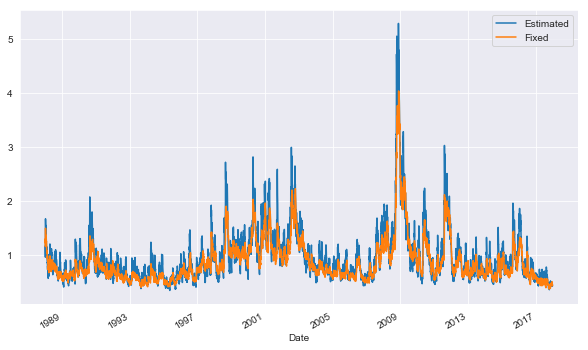

In [10]:
import pandas as pd
df = pd.concat([res.conditional_volatility,fixed_res.conditional_volatility],1)
df.columns = ['Estimated', 'Fixed']
df.plot()

## Building a Model From Components

Models can also be systematically assembled from the three model components:

* A mean model (`arch.mean`)
    * Zero mean (`ZeroMean`) - useful if using residuals from a model estimated separately
    * Constant mean (`ConstantMean`) - common for most liquid financial assets
    * Autoregressive (`ARX`) with optional exogenous regressors
    * Heterogeneous (`HARX`) autoregression with optional exogenous regressors
    * Exogenous regressors only (`LS`)
* A volatility process (`arch.volatility`)
    * ARCH (`ARCH`)
    * GARCH (`GARCH`)
    * GJR-GARCH (`GARCH` using `o` argument) 
    * TARCH/ZARCH (`GARCH` using `power` argument set to `1`)
    * Power GARCH and Asymmetric Power GARCH (`GARCH` using `power`)
    * Exponentially Weighted Moving Average Variance with estimated coefficient (`EWMAVariance`)
    * Heterogeneous ARCH (`HARCH`)
    * Parameterless Models
        * Exponentially Weighted Moving Average Variance, known as RiskMetrics (`EWMAVariance`)
        * Weighted averages of EWMAs, known as the RiskMetrics 2006 methodology (`RiskMetrics2006`)
* A distribution (`arch.distribution`)
    * Normal (`Normal`)
    * Standardized Students's T (`StudentsT`)

### Mean Models

The first choice is the mean model.  For many liquid financial assets, a constant mean (or even zero) is adequate.  For other series, such as inflation, a more complicated model may be required.  These examples make use of Core CPI downloaded from the [Federal Reserve Economic Data](http://research.stlouisfed.org/fred2/) site.

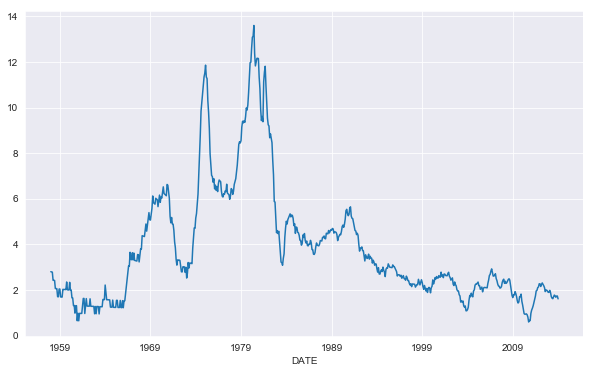

In [11]:
core_cpi = web.DataReader("CPILFESL", "fred", dt.datetime(1957,1,1), dt.datetime(2014,1,1))
ann_inflation = 100 * core_cpi.CPILFESL.pct_change(12).dropna()
fig = ann_inflation.plot()

All mean models are initialized with constant variance and normal errors.  For `ARX` models, the `lags` argument specifies the lags to include in the model.

In [12]:
from arch.univariate import ARX
ar = ARX(ann_inflation, lags = [1, 3, 12])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:               CPILFESL   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:          Constant Variance   Log-Likelihood:               -13.7178
Distribution:                  Normal   AIC:                           37.4356
Method:            Maximum Likelihood   BIC:                           59.9043
                                        No. Observations:                  661
Date:                Sun, Aug 19 2018   Df Residuals:                      656
Time:                        21:33:07   Df Model:                            5
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0424  2.197e-02      1.929  5.

### Volatility Processes

Volatility processes can be added a a mean model using the `volatility` property.  This example adds an ARCH(5) process to model volatility. The arguments `iter` and `disp` are used in `fit()` to suppress estimation output.

In [13]:
from arch.univariate import ARCH, GARCH
ar.volatility = ARCH(p=5)
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                           AR - ARCH Model Results                            
Dep. Variable:               CPILFESL   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:                       ARCH   Log-Likelihood:                83.8447
Distribution:                  Normal   AIC:                          -147.689
Method:            Maximum Likelihood   BIC:                          -102.752
                                        No. Observations:                  661
Date:                Sun, Aug 19 2018   Df Residuals:                      651
Time:                        21:33:08   Df Model:                           10
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0268  2.207e-02      1.212    

Plotting the standardized residuals and the conditional volatility shows some large (in magnitude) errors, even when standardized.

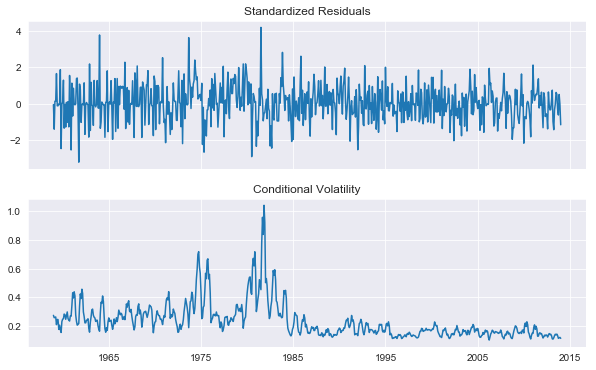

In [14]:
fig = res.plot()

### Distributions

Finally the distribution can be changed from the default normal to a standardized Student's T using the `distribution` property of a mean model.

The Student's t distribution improves the model, and the degree of freedom is estimated to be near 8.

In [15]:
from arch.univariate import StudentsT
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                              AR - ARCH Model Results                               
Dep. Variable:                     CPILFESL   R-squared:                       0.991
Mean Model:                              AR   Adj. R-squared:                  0.991
Vol Model:                             ARCH   Log-Likelihood:                89.4699
Distribution:      Standardized Student's t   AIC:                          -156.940
Method:                  Maximum Likelihood   BIC:                          -107.509
                                              No. Observations:                  661
Date:                      Sun, Aug 19 2018   Df Residuals:                      650
Time:                              21:33:09   Df Model:                           11
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

## WTI Crude

The next example uses West Texas Intermediate Crude data from FRED.  Theee models are fit using alternative distributional assumptions.  The results are printed, where we can see that the normal has a much lower log-likelihood than either the Standard Student's T or the Standardized Skew Student's T -- however, these two are fairly close.  The closeness of the T and the Skew T indicate that returns are not heavily skewed.

In [16]:
from collections import OrderedDict
crude=web.get_data_fred('DCOILWTICO',dt.datetime(2000, 1, 1),dt.datetime(2015, 1, 1))
crude_ret = 100 * crude.dropna().pct_change().dropna()
res_normal = arch_model(crude_ret).fit(disp='off')
res_t = arch_model(crude_ret, dist='t').fit(disp='off')
res_skewt = arch_model(crude_ret, dist='skewt').fit(disp='off')
lls = pd.Series(OrderedDict((('normal', res_normal.loglikelihood),
                 ('t', res_t.loglikelihood),
                 ('skewt', res_skewt.loglikelihood))))
print(lls)
params = pd.DataFrame(OrderedDict((('normal', res_normal.params),
                 ('t', res_t.params),
                 ('skewt', res_skewt.params))))
print(params)

normal   -8227.359031
t        -8128.534732
skewt    -8126.303934
dtype: float64
            normal         t     skewt
alpha[1]  0.054488  0.046069  0.045908
beta[1]   0.940953  0.949954  0.950364
lambda         NaN       NaN -0.048593
mu        0.065643  0.076392  0.057599
nu             NaN  6.841493  6.889696
omega     0.034733  0.026497  0.025239


The standardized residuals can be computed by dividing the residuals by the conditional volatility.  These are plotted along with the (unstandardized, but scaled) residuals. The non-standardized residuals are more peaked in the center indicating that the distribution is somewhat more heavy tailed than that of the standardized residuals.

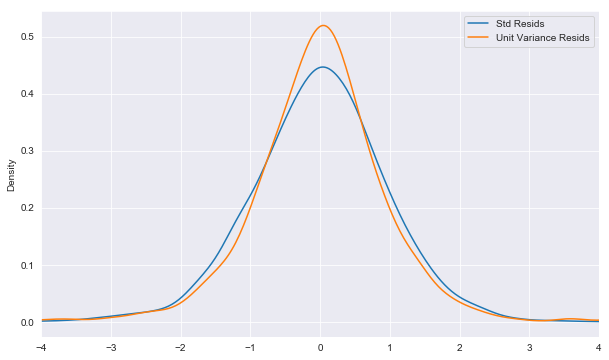

In [17]:
std_resid = res_normal.resid / res_normal.conditional_volatility
unit_var_resid = res_normal.resid / res_normal.resid.std()
df = pd.concat([std_resid, unit_var_resid],1)
df.columns = ['Std Resids', 'Unit Variance Resids']
df.plot(kind='kde', xlim=(-4,4))